In [ ]:
'''
-Lite work in progress kring att öppna och analysera tweets.
-Notebooken måste ligga i samma mapp som all data. 
-Rekommenderar att inte köra alla celler, kan nog ta ett tag
 när vi börjar få ihop mer data.
'''

In [1]:
#installera pandas och matplotlib, 
# och numpy om den inte kommer automatiskt med pandas
import json
import glob
import os
import re
import pandas as pd
import numpy as np
import time

In [3]:
#Printar lite extra grejs som kan vara intressant om saker går fel
DEBUG = True

In [4]:
#Genererar ett filträd. Måste ligga i samma mapp som datamapparna
# tree[date][industry][company][handle] är en lista med alla filer för den användaren (alltså: mentions, till, från).  

#TESTAD 19/3, Patrik har kontrollerat att längden på fillistan stämmer överrens med antal jsonfiler och att filnamn
# inte förekommer dubbelt. Koden är testad när notebooken ligger i samma mapp som två datamappar (2020-03-18, 2020-03-19).


tree = {}
INDUSTRIES = ["Airlines"]

#Lista med alla mappar i working directory som heter något i stil med 1111-11-11
collections = [d for d in glob.glob("*") if re.fullmatch(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', d)]

for col in collections:
    tree[col] = {}
    for ind in INDUSTRIES:
        tree[col][ind] = {}
        
        #Den här fångar alla undermappar i /2020-xx-xx/<industry>/
        companies = [os.path.basename(x) for x in glob.glob(os.path.join(col, ind, "*"))]
        
        for comp in companies:
            tree[col][ind][comp] = {}
            
            #Traskar igenom "underfilträdet" för varje företag, alltså med /2020-xx-xx/industry/company/ som root. 
            #Lite snårig men finns bra dokumentation online.
            for root, dirs, files in os.walk(os.path.join(col, ind, comp), topdown=True):
                if dirs:
                    for handle in dirs:
                        tree[col][ind][comp][handle] = []
                else:
                    for f in files:
                        if f.find("tweet") == 0:
                            tree[col][ind][comp][os.path.basename(root)].append(os.path.join(root, f))
                            
#Printar en översikt av hela filträdet
if DEBUG:
    for c in tree.keys():
        print(c)
        for ind in tree[c].keys():
            print('\t', ind)
            for comp in tree[c][ind].keys():
                print('\t\t', comp)
                for handle in tree[c][ind][comp].keys():
                    print('\t\t\t', handle)
                    print('\t\t\t', "antal json:", str(len(tree[c][ind][comp][handle])))
                    for f in tree[c][ind][comp][handle]:
                        print('\t\t\t\t', f)

2020-03-18
	 Airlines
		 Aer Lingus
			 @AerLingus
			 antal json: 20
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_1.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_10.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_11.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_12.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_13.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_14.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_15.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_16.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_17.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_18.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_19.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_2.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_20.json
				 2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_3.json
				 2020

				 2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_6.json
				 2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_7.json
				 2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_8.json
				 2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_9.json
2020-03-25
	 Airlines
		 Aer Lingus
			 @AerLingus
			 antal json: 10
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_1.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_10.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_2.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_3.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_4.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_5.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_6.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_7.json
				 2020-03-25/Airlines/Aer Lingus/@AerLingus/tweet_list_8.json
				 2020-03-25/Airlines/Aer Lingus/@Aer

				 2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_4.json
				 2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_5.json
				 2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_6.json
				 2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_7.json
				 2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_8.json
		 easyJet
			 @easyJet
			 antal json: 38
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_1.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_10.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_11.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_12.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_13.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_14.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_15.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_16.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_17.json
				 2020-04-01/Airlines/easyJet/@easyJet/tweet_list_18.json
			

In [107]:
#Enkel tweeträknare, läser all data så kan ju ta ett tag. 
#Testad för två samlingar (2020-03-18, 2020-03-19)
#OBS, dubbelräknar totalen!
counts = {}
for date in tree.keys():
    counts[date] = {}
    for industry in tree[date].keys():
        for company in tree[date][industry].keys():
            for handle in tree[date][industry][company].keys():
                counts[date][handle] = 0
                for path in tree[date][industry][company][handle]:
                    if DEBUG:
                        print(path)
                    with open(path, 'r') as f:
                        tweet_list = json.loads(f.read())
                    counts[date][handle] += len(tweet_list)
                    
print("Counts: ")
total = 0 #OBS total dubbelräknar tweets om samma tweets finns i olika samlingar. 
for date in counts.keys():
    print(date)
    for handle in counts[date].keys():
        print("\t", handle, counts[date][handle])
        total += counts[date][handle]
print("total:", total)

2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_1.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_10.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_11.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_12.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_13.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_14.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_15.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_16.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_17.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_18.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_19.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_2.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_20.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_3.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_4.json
2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_5.json
2020-03-18/Airlines/Aer Lingu

2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_24.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_25.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_26.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_27.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_28.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_29.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_3.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_30.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_31.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_32.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_33.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_34.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_35.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_36.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_37.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_38.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_39.json
2020-03-18/Airlines/Ryanair/@Ryanair/tweet_list_4

2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_38.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_39.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_4.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_40.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_41.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_42.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_43.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_44.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_45.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_46.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_47.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_5.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_6.json
2020-03-19/Airlines/British Airways/@British_Airways/tweet_list_7.j

2020-03-25/Airlines/Turkish Airlines/@TurkishAirlines/tweet_list_4.json
2020-03-25/Airlines/Turkish Airlines/@TurkishAirlines/tweet_list_5.json
2020-03-25/Airlines/Turkish Airlines/@TurkishAirlines/tweet_list_6.json
2020-03-25/Airlines/Turkish Airlines/@TurkishAirlines/tweet_list_7.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_1.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_10.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_2.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_3.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_4.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_5.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_6.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_7.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_8.json
2020-03-25/Airlines/Vueling Airlines/@vueling/tweet_list_9.json
2020-03-25/Airlines/easyJet/@easyJet/tweet_list_1.json
2020-03-25/Airli

2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_1.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_2.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_3.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_4.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_5.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_6.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_7.json
2020-04-01/Airlines/Vueling Airlines/@vueling/tweet_list_8.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_1.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_10.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_11.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_12.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_13.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_14.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_15.json
2020-04-01/Airlines/easyJet/@easyJet/tweet_list_16.json
2020-04-01/Airlines/easyJet/@easyJet/twee

In [9]:
#Läser in allt i flera DataFrames och skriver ut hur lång tid det tog.
#ITEMS är de fält som tas med. Filtrerar direkt för att spara minne.
ITEMS = ["created_at", "full_text", "id", "id_str", "metadata", "in_reply_to_status_id", "user", "retweeted_status", "in_reply_to_screen_name"]

#dictionary för alla DataFrames
frames = {}

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
    companies = [company["name"] for company in json_list]
for company in companies:
    frames[company] = [] 
t_start = time.time()
for day in tree.keys():
    for company in tree[day]["Airlines"].keys():
        for path in list(tree[day]["Airlines"][company].values())[0]:
            df = pd.read_json(path)
            #Ta bort alla fält som inte finns i items
            df = df.filter(items=ITEMS)
            #Ta bort retweets
            df = df[df["retweeted_status"].isnull()]
            #Skapa en bool-series baserat på språket och behåll endast kolumner där språket känns igen som engelska.
            en = df.metadata.apply(lambda x: x["iso_language_code"] == "en")
            df = df[en]
            #Plocka ut id och screen name från user, de får egna kolumner
            df["user.id"] = df.user.apply(lambda x: x["id"])
            df["user.screen_name"] = df.user.apply(lambda x: x["screen_name"])
            #Lägg till kolumner som anger vilket företag tweeten insamlats från (alltså EJ avsändaren), samt insamlingsdatum
            df["associated_company"]=company
            df["collection_date"]=day
            #Ta bort kolumner vi inte använder
            df = df.drop(["metadata", "user"], axis=1)
            #Lägg till i dictionaryt
            frames[company].append(df)
    
print("Time - read files:", time.time()-t_start, "seconds")



Time - read files: 337.3045382499695 seconds


In [15]:
#Styr upp all inläst data.
#Slår ihop alla listor i frames så att varje företag får en egen DataFrame. 
# -Alla tweets i ett företags sammanslagna DataFrame är unika. 
# -Samma tweet kan förekomma i två olika företags DataFrames 
#       (om de tex har taggat flera företag eller svarat ett företag och taggat ett annat)
#Skapar även en DataFrame all_data där alla DataFrames från olika företag slås ihop
# -Alla tweets i all_data är unika.
# -Kolumnen "associated_company" i all_data är alltså oren eftersom tweets som taggar flera företag här endast
#    tillhör det företag som programmet såg först.

#DUPLICATES SYFTAR ALLTSÅ PÅ ATT TWEETS SOM TAGGAR FLERA FÖRETAG RÄKNAS DUBBELT, INTE ATT DE SAMLATS IN DUBBELT

#totala antalet tweets i dictionaryt frames
total_dup = 0
#totala minnesanvändningen för frames + all_data
total_memory = 0
all_data = []
for company in companies:
    #slår ihop alla DataFrames för ett företag till en enda och tar bort dubbelinsamlade tweets för det företaget.
    frames[company] = pd.concat(frames[company])
    frames[company] = frames[company].drop_duplicates(subset="id")
    #Lägger till den framen till all_data
    all_data.append(frames[company])
    
    total_dup += frames[company].shape[0]
    mem = frames[company].memory_usage(index=True, deep=True).sum() / 1000000
    total_memory += mem
    #Skriver ut antalet unika tweets för varje företag och hur mycket minne som går åt (mest för kontroll)
    print(company, "- tweets:", frames[company].shape[0], "- memory:", mem)
#Slår ihop all_data till en frame och tar bort duplicates
all_data = pd.concat(all_data)
all_data = all_data.drop_duplicates(subset="id")
mem = all_data.memory_usage(index=True, deep=True).sum() / 1000000
total_memory+=mem
#Skriver ut totala antalet unika tweets och hur mycket minne all_data tar
print("all_data - tweets:", all_data.shape[0], "-memory:", mem)
#Skriver ut summan av antalet tweets för varje företag, samt totala minnesanvändningen (frames + all_data)
#Se ovan exakt vad som menas med duplicates.
print("total (with duplicates) - tweets:", total_dup, "- memory:", total_memory)

Lufthansa Group - tweets: 13832 - memory: 8.833491
Air France-KLM - tweets: 6187 - memory: 3.991273
British Airways - tweets: 84950 - memory: 57.345967
Iberia - tweets: 4214 - memory: 2.58386
Aer Lingus - tweets: 29273 - memory: 18.826525
Vueling Airlines - tweets: 3670 - memory: 2.392378
Ryanair - tweets: 53333 - memory: 34.495797
Aeroflot Group - tweets: 1222 - memory: 0.795153
Turkish Airlines - tweets: 5762 - memory: 3.784566
easyJet - tweets: 87648 - memory: 56.490867
SAS Group - tweets: 4162 - memory: 2.507575
Norwegian Air - tweets: 8695 - memory: 5.921082
TAP Air Portugal - tweets: 7614 - memory: 4.833681
Alitalia - tweets: 2220 - memory: 1.372903
Jet2.com - tweets: 23588 - memory: 15.318319
Pegasus Airlines - tweets: 679 - memory: 0.445524
Flybe - tweets: 761 - memory: 0.504946
Finnair - tweets: 2002 - memory: 1.293213
all_data - tweets: 331542 -memory: 215.636771
total (with duplicates) - tweets: 339812 - memory: 437.37389100000007


/home/user/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


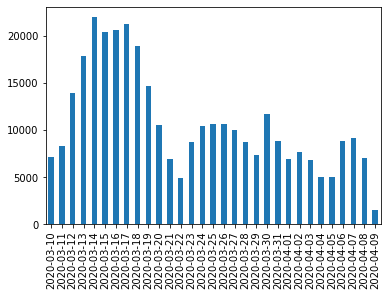

In [16]:
#Exempel på plot av antal tweets per dag. Tror den gör vad jag säger att den gör...
all_data["created_at"].dt.to_period("D").value_counts().sort_index().plot(kind="bar")